# Silcton MRI Processing and Analyses

Data, info on Virtual Silcton, analysis plan can all be found here: https://osf.io/ea99d/

# Importing various packages and creating a few useful functions

In [1]:
#import packages

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
import pandas as pd
import scipy
import seaborn as sns
from sklearn.cluster import KMeans
from statsmodels.formula.api import ols
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline

# do you want to save all figures?
saveFigFlag = False

In [2]:
def zscore(column, data):
    #Calculate and return the z-score value of a variable from a DataFrame
    zscoredVariable = (data[column] - data[column].mean())/data[column].std(ddof=0)
    return zscoredVariable

In [3]:
def doAnova(dependentVar,data,groups='int1non2imp3'):
    if groups == 'int1non2imp3':
        nums = [1,2,3]
    elif groups == 'kmeans_reclustering':
        nums = [0,1,2]
    data = data[np.isfinite(data[dependentVar])]
    grps = pd.unique(data[groups].values)
    d_data = {grp:data[dependentVar][data[groups] == grp] for grp in grps}
    F, p = scipy.stats.f_oneway(d_data[nums[0]], d_data[nums[1]], d_data[nums[2]])
    print('F = ',F,'p = ',p)

In [4]:
def stderror(dependentVar):
    std = np.std(dependentVar)
    n = len(dependentVar)
    sem = std / np.sqrt(n)
    
    return sem

In [5]:
def pearsonRtoT(xname,yname,data):
    """Transform a Pearson R into a t-value for Bayes calculator"""
    x = data.loc[:,xname]
    y = data.loc[:,yname]
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    n = len(data[xname])
    t = np.sqrt((n-2)*(r_value**2)/(1-r_value**2))
    
    print('The correlation between {} and {} is r({}) = {:.2f}, p = {:.2f}. T-value = {:.2f}'.format(xname, yname,n,r_value, p_value,t))



In [6]:
def formatPlot(x,y,plot,linecolor,ax1):
    ax1.set_xlabel(x.name,fontsize=20)
    ax1.set_ylabel(y.name,fontsize=20)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    fit = np.polyfit(x, y, deg=1) # calculate regression line
    ax1.plot(x, fit[0] * x + fit[1], color=linecolor,label='',linewidth=2) # print lines as black
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    pearsonR = 'r = ' + "{0:.2f}".format(r_value)
    locationOffset = (min(y) - max(y)) / 10
    location = (max(x)*fit[0] + fit[1]) + locationOffset
    ax1.text(max(x),location,pearsonR,horizontalalignment='right',fontsize=14,color=linecolor)
    ax1.legend(edgecolor='black',fontsize=14)
    fig = plt.gcf()
    fig.set_size_inches(10.5, 10.5)



In [7]:
def makeNavGroupPlot(xname,yname,data,groups='int1non2imp3',savefig=False,title=""):

    """Will make a formatted scatter plot colored by all three groups"""
    if groups == 'int1non2imp3':
        nums = [1,2,3]
    elif groups == 'kmeans_reclustering':
        nums = [0,1,2]
        
    x = data.loc[:,xname]
    y = data.loc[:,yname]
    f, ax1 = plt.subplots(1)
    group_dict = {nums[0]:['#00B050','Integrators'],nums[1]:['#E46C0A','Non-Integrators'],nums[2]:['#4BACC6','Imprecise Navigators']}

    for kind in group_dict:
        d = data[data[groups]==kind]
        plt.scatter(d.loc[:,xname], d.loc[:,yname],
            c = group_dict[kind][0],label=group_dict[kind][1],s=60)
        plt.hlines(np.mean(d.loc[:,yname]), np.mean(d.loc[:,xname]) - stderror(d.loc[:,xname]), np.mean(d.loc[:,xname]) + stderror(d.loc[:,xname]), linestyle='dashed')
        plt.vlines(np.mean(d.loc[:,xname]), np.mean(d.loc[:,yname]) - stderror(d.loc[:,yname]), np.mean(d.loc[:,yname]) + stderror(d.loc[:,yname]), linestyle='dashed')
        plt.plot(np.mean(d.loc[:,xname]), np.mean(d.loc[:,yname]), marker='o', markersize=20
                 , color=group_dict[kind][0], markeredgecolor='black')
        formatPlot(d.loc[:,xname],d.loc[:,yname],f,group_dict[kind][0],ax1)

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    pearsonR = 'r = ' + "{0:.2f}".format(r_value)
    
    fit = np.polyfit(x, y, deg=1) # calculate regression line
    ax1.plot(x, fit[0] * x + fit[1], color='gray',label='Total',linewidth=2) # print lines as black

    locationOffset = (max(y) - min(y)) / 20
    location = (max(x)*fit[0] + fit[1]) + locationOffset
    ax1.text(max(x),location,pearsonR,horizontalalignment='right', fontsize=14)
    ax1.set_title(title,fontsize=30)




In [8]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Arguments:
        data       : A 2D numpy array of shape (N,M)
        row_labels : A list or array of length N with the labels
                     for the rows
        col_labels : A list or array of length M with the labels
                     for the columns
    Optional arguments:
        ax         : A matplotlib.axes.Axes instance to which the heatmap
                     is plotted. If not provided, use current axes or
                     create a new one.
        cbar_kw    : A dictionary with arguments to
                     :meth:`matplotlib.Figure.colorbar`.
        cbarlabel  : The label for the colorbar
    All other arguments are directly passed on to the imshow call.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, shrink=.5)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Arguments:
        im         : The AxesImage to be labeled.
    Optional arguments:
        data       : Data used to annotate. If None, the image's data is used.
        valfmt     : The format of the annotations inside the heatmap.
                     This should either use the string format method, e.g.
                     "$ {x:.2f}", or be a :class:`matplotlib.ticker.Formatter`.
        textcolors : A list or array of two color specifications. The first is
                     used for values below a threshold, the second for those
                     above.
        threshold  : Value in data units according to which the colors from
                     textcolors are applied. If None (the default) uses the
                     middle of the colormap as separation.

    Further arguments are passed on to the created text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[im.norm(data[i, j]) > threshold])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

# Import and process data

In [9]:
#import and process data - including Z-scoring all columns

data = pd.read_csv('https://raw.githubusercontent.com/smweis/Silcton_MRI/master/public_data/DataAnalysisWith90Participants_Jupyter.csv')

data['pointBetweenUnreverse'] = data['pointBetween']
data['pointWithinUnreverse'] = data['pointWithin']
data['pointTotalUnreverse'] = data['pointTotal']
data['saqUnreverse'] = data['saq']

#reverse the pointing ones to be higher = good score
data['pointBetween'] = -1*(data['pointBetween'])
data['pointWithin'] = -1*(data['pointWithin'])
data['pointTotal'] = -1*(data['pointTotal'])
data['saq'] = -1*(data['saq'])


#Normalize all float variables

for i in data:
    if i in ['Batch','ID','Education','int1non2imp3']:
        continue
    elif data[i].dtype != object:
        data[i+'_zscore'] = zscore(i,data)
    else:    
        continue
        

# Data quality assurance

We want to compare the ASHS segmentation with the freesurfer total segmentation 
and the posterior/anterior ASHS splits with SMW's by hand splits. 
Here are the correlations, which range from r = .63 to r = .87

In [10]:
# The results don't really differ with/without outliers. 
#pearsonRtoT('ashs_rtotalhipp','rhc',dataWithoutOutliers)
#pearsonRtoT('ashs_ltotalhipp','lhc',dataWithoutOutliers)
#pearsonRtoT('ashs_ant_rhc','rhc_head',dataWithoutOutliers)
#pearsonRtoT('ashs_ant_lhc','lhc_head',dataWithoutOutliers)
#pearsonRtoT('ashs_post_rhc','rhc_bodytail',dataWithoutOutliers)
#pearsonRtoT('ashs_post_lhc','lhc_bodytail',dataWithoutOutliers)

pearsonRtoT('ashs_rtotalhipp','rhc',data)
pearsonRtoT('ashs_ltotalhipp','lhc',data)
pearsonRtoT('ashs_ant_rhc','rhc_head',data)
pearsonRtoT('ashs_ant_lhc','lhc_head',data)
pearsonRtoT('ashs_post_rhc','rhc_bodytail',data)
pearsonRtoT('ashs_post_lhc','lhc_bodytail',data)


The correlation between ashs_rtotalhipp and rhc is r(90) = 0.87, p = 0.00. T-value = 16.41
The correlation between ashs_ltotalhipp and lhc is r(90) = 0.81, p = 0.00. T-value = 12.98
The correlation between ashs_ant_rhc and rhc_head is r(90) = 0.76, p = 0.00. T-value = 10.83
The correlation between ashs_ant_lhc and lhc_head is r(90) = 0.68, p = 0.00. T-value = 8.63
The correlation between ashs_post_rhc and rhc_bodytail is r(90) = 0.65, p = 0.00. T-value = 7.95
The correlation between ashs_post_lhc and lhc_bodytail is r(90) = 0.63, p = 0.00. T-value = 7.55


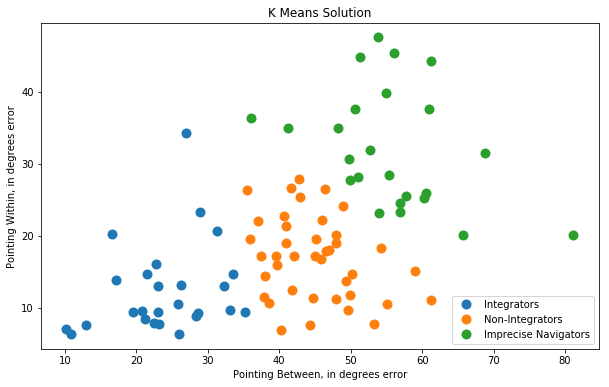

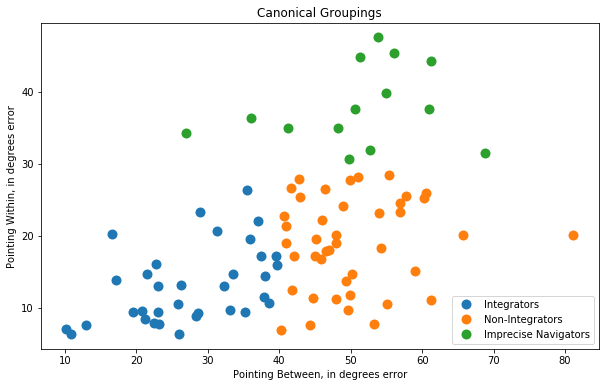

In [11]:
# here, we re-do the clustering for this sample. We see some differences. we'll use both, below.
# But for the main results, we will use the canonical clusters. 
kmeans = KMeans(n_clusters=3,random_state=3425) # a random state to ensure they stay similar grouping as below
X = data.loc[:,('pointBetweenUnreverse','pointWithinUnreverse')]
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
data['kmeans_reclustering'] = y_kmeans

fig, ax = plt.subplots(figsize=(10,6))

for category, selection in data.groupby('kmeans_reclustering'):
    ax.plot(selection['pointBetweenUnreverse'], selection['pointWithinUnreverse'], marker='o', markersize=10, linestyle='', label=category, markeredgewidth=0)
ax.set_ylabel("Pointing Within, in degrees error")
ax.set_xlabel("Pointing Between, in degrees error")
ax.legend(loc='lower right',labels=['Integrators','Non-Integrators','Imprecise Navigators'])
ax.set_title('K Means Solution')
plt.show()
fig, ax = plt.subplots(figsize=(10,6))

for category, selection in data.groupby('int1non2imp3'):
    ax.plot(selection['pointBetweenUnreverse'], selection['pointWithinUnreverse'], marker='o', markersize=10, linestyle='', label=category, markeredgewidth=0)
ax.set_ylabel("Pointing Within, in degrees error")
ax.set_xlabel("Pointing Between, in degrees error")
ax.set_title('Canonical Groupings')
ax.legend(loc='lower right',labels=['Integrators','Non-Integrators','Imprecise Navigators'])

plt.show()

A couple outliers on hippocampal volume. I've run analyses with and without outliers, and they're mostly unchanged. 

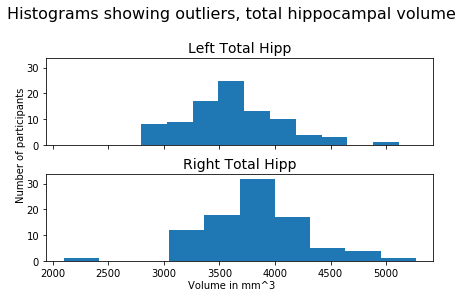

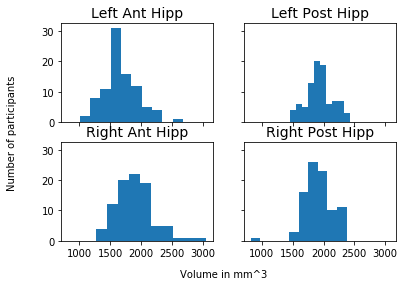

In [12]:
#check any histograms
fig, axes = plt.subplots(2,1,sharey=True, sharex=True)
axes[0].hist(data['ashs_ltotalhipp'])
axes[0].set_title('Left Total Hipp',size=14)
axes[1] .hist(data['ashs_rtotalhipp'])
axes[1].set_title('Right Total Hipp',size=14)
fig.text(0.5, 0.0, 'Volume in mm^3', ha='center')
fig.text(0.0, 0.5, 'Number of participants', va='center', rotation='vertical')

fig.suptitle('Histograms showing outliers, total hippocampal volume',size=16)
fig.tight_layout()
fig.subplots_adjust(top=0.80)

fig, axes = plt.subplots(2,2,sharey=True, sharex=True)
axes[0,0] .hist(data['ashs_ant_lhc'])
axes[0,0].set_title('Left Ant Hipp',size=14)
axes[0,1].hist(data['ashs_post_lhc'])
axes[0,1].set_title('Left Post Hipp',size=14)
axes[1,0] .hist(data['ashs_ant_rhc'])
axes[1,0].set_title('Right Ant Hipp',size=14)
axes[1,1] .hist(data['ashs_post_rhc'])
axes[1,1].set_title('Right Post Hipp',size=14)

fig.text(0.5, 0.0, 'Volume in mm^3', ha='center')
fig.text(0.0, 0.5, 'Number of participants', va='center', rotation='vertical')
plt.show()

fig.suptitle('Histograms showing outliers, anterior and posterior',size=16)
fig.tight_layout()
fig.subplots_adjust(top=0.80)
plt.show()



In [13]:
#exclude outliers from total hippocampal volume (both high and low outliers)
dataWithoutOutliers = data[:]
dataWithoutOutliers = dataWithoutOutliers[dataWithoutOutliers['ashs_rtotalhipp_zscore'] < 3.8]
dataWithoutOutliers = dataWithoutOutliers[dataWithoutOutliers['ashs_rtotalhipp_zscore'] > -3.8]
dataWithoutOutliers = dataWithoutOutliers[dataWithoutOutliers['ashs_ant_rhc_zscore'] < 3.8]
dataWithoutOutliers = dataWithoutOutliers[dataWithoutOutliers['ashs_ant_rhc_zscore'] > -3.8]
print('Our data set without outliers now has', dataWithoutOutliers.shape[0], 'participants and', dataWithoutOutliers.shape[1], 'variables.')


Our data set without outliers now has 88 participants and 127 variables.


# Age and ethnicity demographics.

In [14]:
display(data['gender'].value_counts())
display(data.race.value_counts())
display("Participant's average age was {:.1f} years (SD = {:.2f})".format(data.age.mean(),data.age.std()))

Female    54
Male      36
Name: gender, dtype: int64

White                 39
Asian                 18
Black                 15
Hispanic               7
Hispanic / White       3
Black / Hispanic       2
Black / White          1
Asian / White          1
Asian / Black          1
Other                  1
Do not wish to say     1
Hispanic / Asian       1
Name: race, dtype: int64

"Participant's average age was 23.1 years (SD = 3.94)"

# Pre-registered Analysis

Pre-registered correlations and results

In [15]:
print('ASHS')
pearsonRtoT('ashs_rtotalhipp','pointTotal',data)
print('ASHS without outliers')
pearsonRtoT('ashs_rtotalhipp','pointTotal',dataWithoutOutliers)
print('Freesurfer')
pearsonRtoT('rhc','pointTotal',data)
print('Freesurfer without outliers')
pearsonRtoT('rhc','pointTotal',dataWithoutOutliers)


ASHS
The correlation between ashs_rtotalhipp and pointTotal is r(90) = 0.02, p = 0.88. T-value = 0.15
ASHS without outliers
The correlation between ashs_rtotalhipp and pointTotal is r(88) = 0.10, p = 0.34. T-value = 0.95
Freesurfer
The correlation between rhc and pointTotal is r(90) = 0.07, p = 0.52. T-value = 0.64
Freesurfer without outliers
The correlation between rhc and pointTotal is r(88) = 0.12, p = 0.28. T-value = 1.09


### Scatterplot for ASHS data

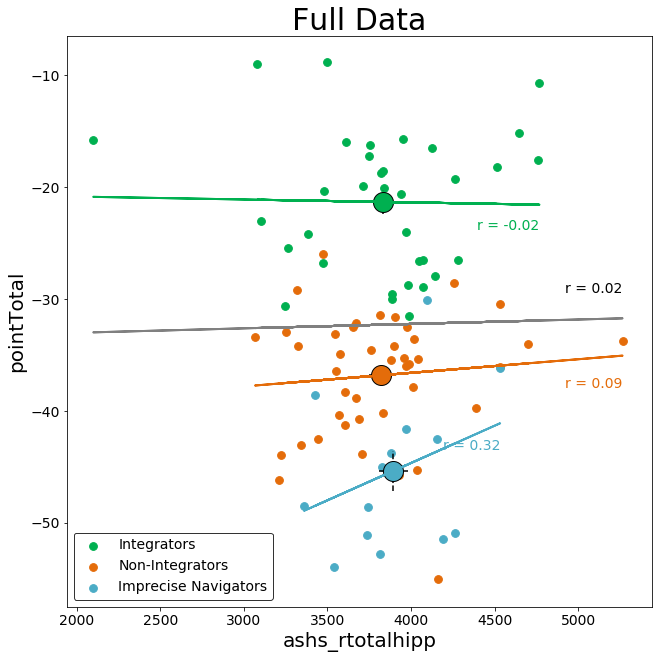

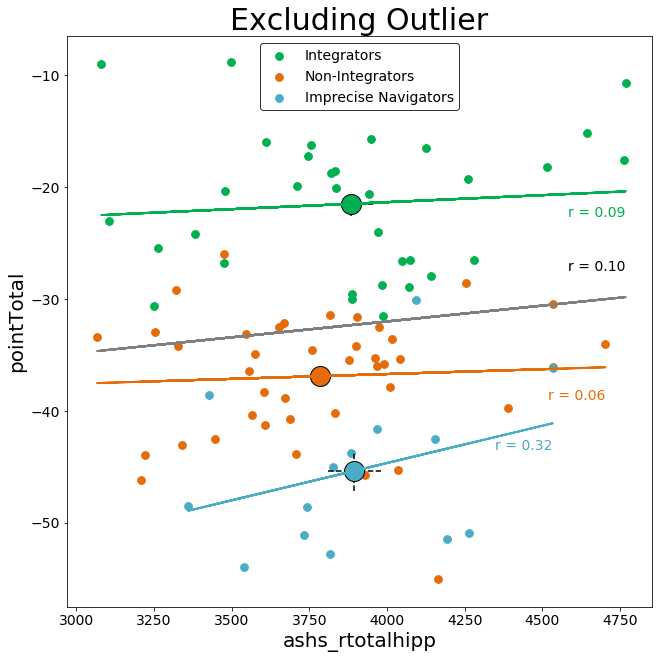

In [16]:
makeNavGroupPlot('ashs_rtotalhipp','pointTotal',data,title='Full Data')
if saveFigFlag:
    plt.savefig('ashs_rtotalhipp_pointTotal.pdf', transparent=True)

makeNavGroupPlot('ashs_rtotalhipp','pointTotal',dataWithoutOutliers,title='Excluding Outlier')
if saveFigFlag:
    plt.savefig('ashs_rtotalhipp_pointTotal_NoOutliers.pdf', transparent=True)

### Scatterplot for freesurfer data

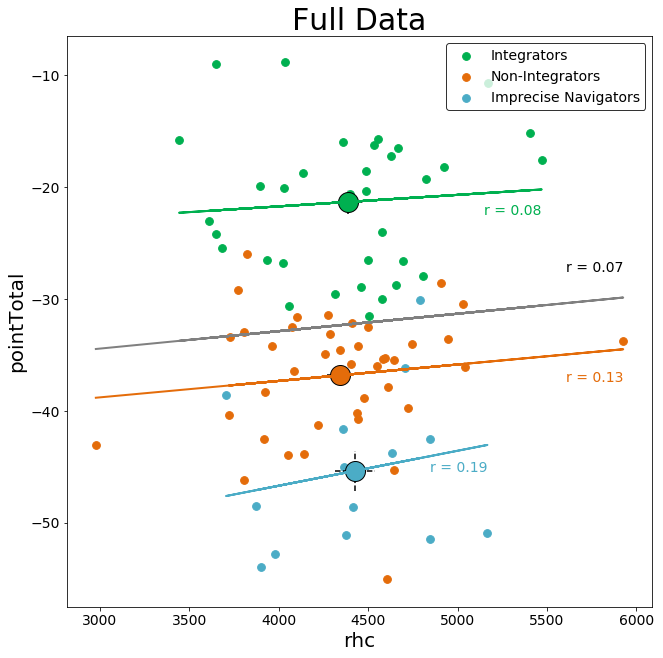

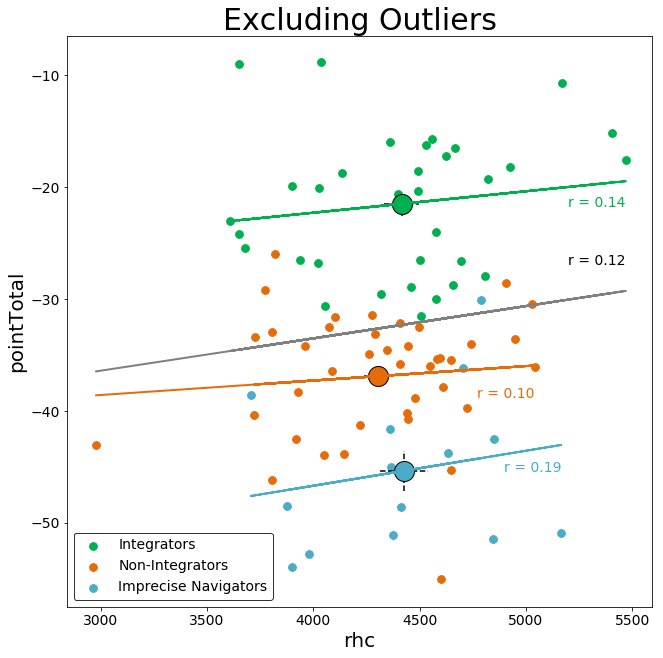

In [17]:
makeNavGroupPlot('rhc','pointTotal',data,title='Full Data')
makeNavGroupPlot('rhc','pointTotal',dataWithoutOutliers,title='Excluding Outliers')

# Multiple Regression Control Analyses

In [44]:
# additional analyses for control

# Total pointing with right hippocampal volume, controlling for MRT, WRAT, age, cortical volume, gender
# number of participants = 82, because 8 participants have no WRAT data. 
model_string = "pointTotal_zscore ~ ashs_rtotalhipp_zscore + mrt_zscore + wrat_zscore + age_zscore + brainVol_zscore + gender"
model_fit = ols(model_string, data).fit()
display(model_fit.summary())


# Total pointing, with right posterior hippocampal volume, controlling for MRT, WRAT, age, cortical volume, gender
model_string = "pointTotal_zscore ~ ashs_post_rhc_zscore + mrt_zscore + wrat_zscore + age_zscore + brainVol_zscore + gender"
model_fit = ols(model_string, data).fit()
display(model_fit.summary())


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      pointTotal_zscore   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     3.366
Date:                Mon, 24 Sep 2018   Prob (F-statistic):            0.00542
Time:                        13:51:24   Log-Likelihood:                -104.56
No. Observations:                  82   AIC:                             223.1
Df Residuals:                      75   BIC:                             240.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.0923      0.143     -0.644      0.521      -0.378       0.193
gender[T.Male]             0.2758      0.256      1.078      0.285      -0.234       0.786
ashs_rtotalhipp_zscore    -0.0496      0.123     -0.402      0.689      -0.295       0.196
mrt_zscore                 0.2986      0.106      2.829      0.006       0.088       0.509
wrat_zscore                0.2186      0.105      2.086      0.040       0.010       0.427
age_zscore                 0.1451      0.101      1.440      0.154      -0.056       0.346
brainVol_zscore            0.0093      0.137      0.068      0.946      -0.263       0.281
==============================================================================
Omnibus:                        0.781   Durbin-Watson:                   2.272
Prob(Omnibus):                  0.677   Jarque-Bera (JB):                0.854
Skew:                          -0.110   Prob(JB):                        0.653
Kurtosis:                       2.551   Cond. No.                         3.90
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      pointTotal_zscore   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     3.376
Date:                Mon, 24 Sep 2018   Prob (F-statistic):            0.00531
Time:                        13:51:24   Log-Likelihood:                -104.53
No. Observations:                  82   AIC:                             223.1
Df Residuals:                      75   BIC:                             239.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.0917      0.143     -0.642      0.523      -0.376       0.193
gender[T.Male]           0.2718      0.254      1.070      0.288      -0.234       0.778
ashs_post_rhc_zscore    -0.0514      0.111     -0.461      0.646      -0.273       0.171
mrt_zscore               0.3012      0.105      2.856      0.006       0.091       0.511
wrat_zscore              0.2177      0.105      2.079      0.041       0.009       0.426
age_zscore               0.1441      0.101      1.430      0.157      -0.057       0.345
brainVol_zscore          0.0047      0.130      0.036      0.971      -0.254       0.264
==============================================================================
Omnibus:                        0.749   Durbin-Watson:                   2.276
Prob(Omnibus):                  0.687   Jarque-Bera (JB):                0.826
Skew:                          -0.100   Prob(JB):                        0.662
Kurtosis:                       2.551   Cond. No.                         3.78
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      pointTotal_zscore   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     2.110
Date:                Mon, 24 Sep 2018   Prob (F-statistic):              0.150
Time:                        13:51:24   Log-Likelihood:                -126.64
No. Observations:                  90   AIC:                             257.3
Df Residuals:                      88   BIC:                             262.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -3.782e-16      0.105  -3.59e-15      1.000      -0.209       0.209
brainVol_zscore     0.1530      0.105      1.453      0.150      -0.056       0.362
==============================================================================
Omnibus:                        0.831   Durbin-Watson:                   2.263
Prob(Omnibus):                  0.660   Jarque-Bera (JB):                0.846
Skew:                           0.033   Prob(JB):                        0.655
Kurtosis:                       2.530   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Exploratory Analyses

These next correlation tables are excerpted from the larger correlation table of all behavioral and brain measures. They're a little easier to see this way. 

Re statistical significance: A significant correlation uncorrected with our sample size is ~ r = .21. Correcting for all possible pairwise correlations yields a sig. threshold of approximately r = .38 (absolute value). None of the behavioral/brain correlations reach this latter threshold, although that is arguably overly strict. 



## Silcton measures with brain measures

In [19]:
silcton_measures = ['pointTotal','pointWithin','pointBetween']
other_silcton_measures = ['buildingNamingLax','Model_Building_Total','Model_Building_Within_Average'] 
non_silcton_measures = ['wrat','sbsod','saq','mrt']
hipp_measures = ['ashs_rtotalhipp','ashs_post_rhc','ashs_ant_rhc','ashs_ltotalhipp','ashs_post_lhc','ashs_ant_lhc']
other_brain_measures = ['rcaud','lcaud','ramyg','lamyg','cortexVol','brainVol']
non_ashs_hipp_measures = ['rhc','rhc_bodytail','rhc_head','lhc','lhc_bodytail','lhc_head']
all_hipp_measures = ['rhc','ashs_rtotalhipp','rhc_bodytail','ashs_post_rhc','rhc_head','ashs_ant_rhc','lhc','ashs_ltotalhipp',
                    'lhc_bodytail','ashs_post_lhc','lhc_head','ashs_ant_lhc']
all_measures = silcton_measures+other_silcton_measures+non_silcton_measures+hipp_measures+other_brain_measures


def corrPlot(xAxis,yAxis,data,max_corr = .38, min_corr = -.38,xSize=10,ySize=10):
    heatMap = pd.DataFrame(np.empty([len(xAxis),len(yAxis)]))
    
    
    
    for i,j in enumerate(xAxis):
        for k,l in enumerate(yAxis):
            corrVal = np.corrcoef(data[j],data[l])
            if np.isnan(corrVal[0,1]):
                corrVal=np.corrcoef(data.dropna()[j],data.dropna()[l])
            heatMap.iloc[i,k] = corrVal[0,1]

    fig, ax = plt.subplots(figsize=[xSize,ySize])
    im, cbar = heatmap(heatMap, xAxis, yAxis, ax=ax,
                       cmap="coolwarm", cbarlabel="Correlation",vmin=min_corr,vmax=max_corr)
    texts = annotate_heatmap(im, valfmt="{x:.2f}", fontsize=14,textcolors=['black','black'])
    return heatMap

C:\Users\stweis\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:106: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


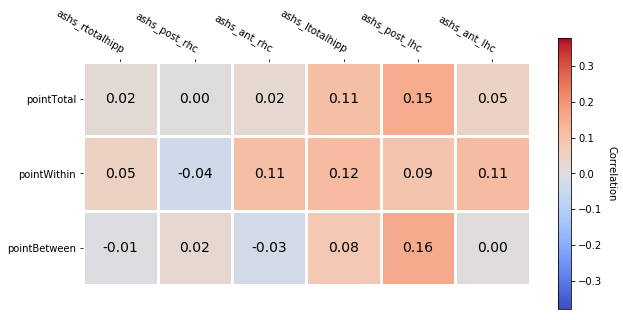

In [20]:
noReturn = corrPlot(silcton_measures,hipp_measures,data)
if saveFigFlag:
    plt.savefig('silcton_with_hipp_measures_corrPlot.pdf', transparent=True)
plt.show()



C:\Users\stweis\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:106: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


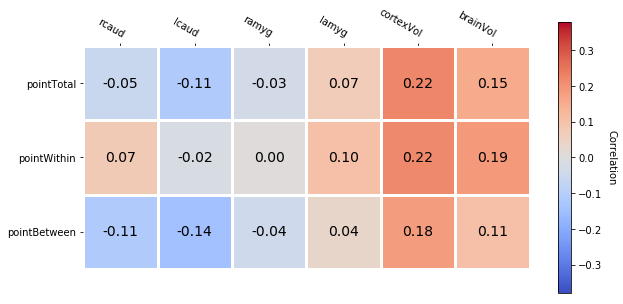

In [21]:
noReturn = corrPlot(silcton_measures,other_brain_measures,data)
if saveFigFlag:
    plt.savefig('silcton_with_other_brain_measures_corrPlot.pdf', transparent=True)
plt.show()



ashs_rtotalhipp
F =  0.14974307427260494 p =  0.8611505554141307


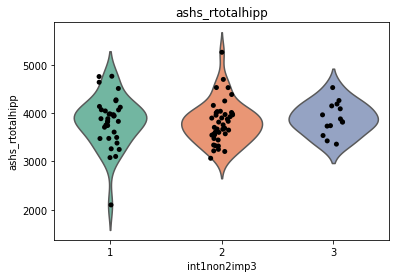

ashs_post_rhc
F =  0.683758846862447 p =  0.5074076067157823


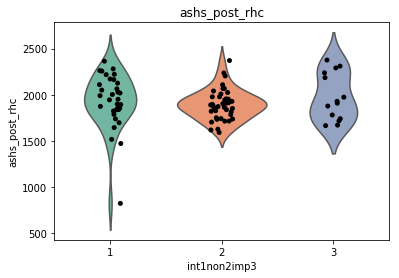

ashs_ant_rhc
F =  0.05702415496354246 p =  0.9446065275955781


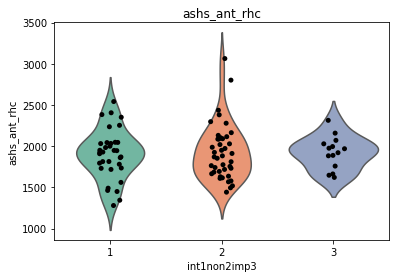

ashs_ltotalhipp
F =  0.419531078248936 p =  0.6586777048333141


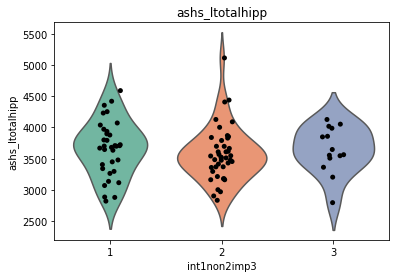

ashs_post_lhc
F =  2.528717601019455 p =  0.08561041535200731


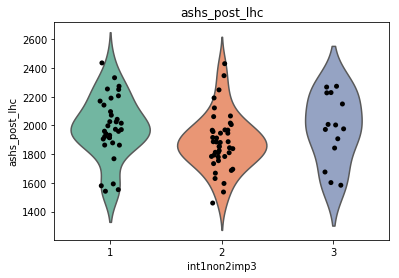

ashs_ant_lhc
F =  0.04700834620507378 p =  0.9541036509262688


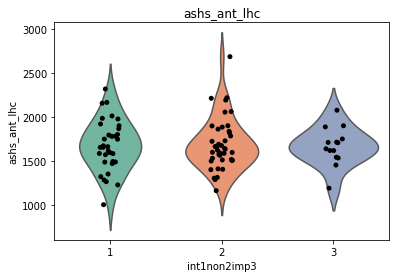

rcaud
F =  0.8481307912108301 p =  0.4317240788899003


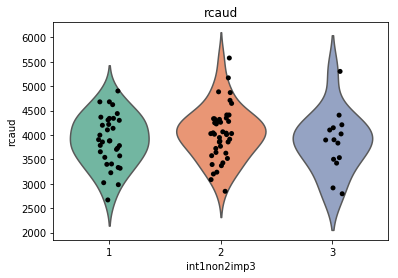

lcaud
F =  0.7553604383520712 p =  0.472897263756735


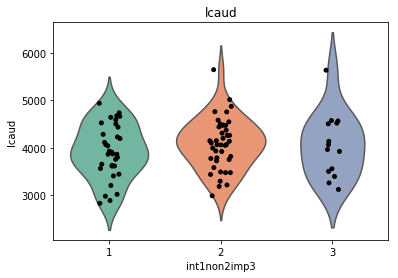

ramyg
F =  0.050261985895830356 p =  0.9510078417377427


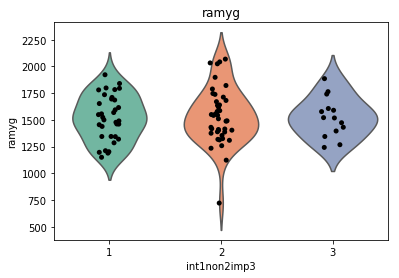

lamyg
F =  0.18517618898692148 p =  0.8312845171297106


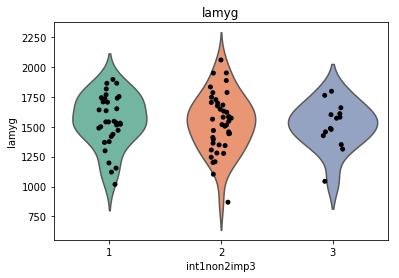

cortexVol
F =  0.7497047865048788 p =  0.47553364600677284


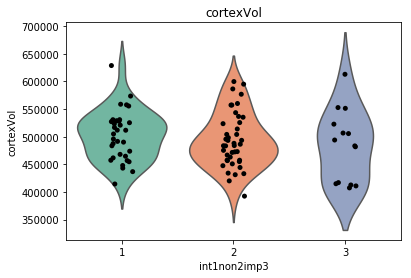

brainVol
F =  1.0680617947002045 p =  0.3481365782429522


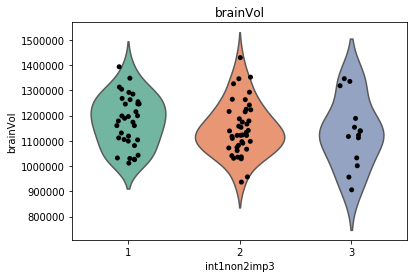

In [22]:
for i in hipp_measures + other_brain_measures:
    print(i)
    doAnova(i,data,groups='int1non2imp3')
    sns.violinplot(x='int1non2imp3',y=i,data=data,inner=None,palette='Set2')
    sns.stripplot(x='int1non2imp3',y=i,data=data,jitter=True,color='black')
    plt.title(i)
    plt.show()

## Other Silcton measures with hippocampus measures

C:\Users\stweis\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:106: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


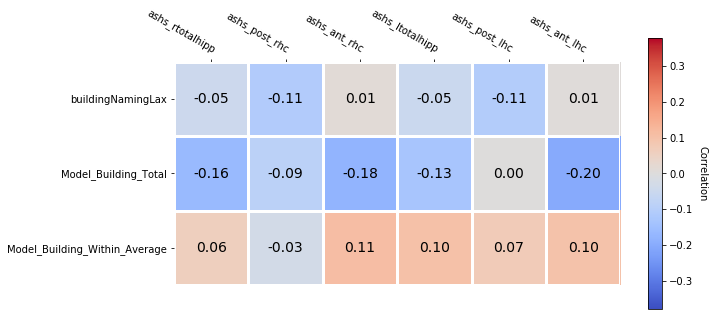

In [23]:
noReturn = corrPlot(other_silcton_measures,hipp_measures,data)

if saveFigFlag:
    plt.savefig('other_silcton_with_hipp_measures_corrPlot.pdf', transparent=True)

plt.show()


## Other Silcton measures with other brain measures

C:\Users\stweis\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:106: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


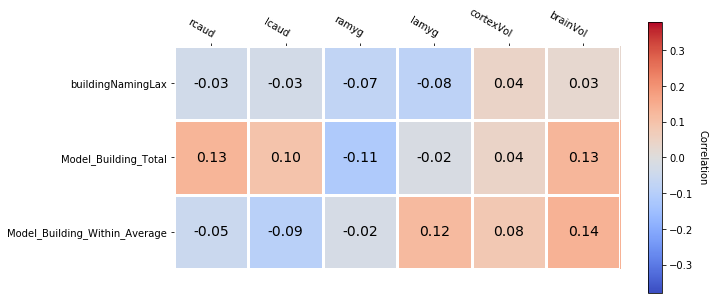

In [24]:
noReturn = corrPlot(other_silcton_measures,other_brain_measures,data)
if saveFigFlag:
    plt.savefig('other_silcton_with_other_brain_measures_corrPlot.pdf', transparent=True)
plt.show()




In [25]:
for i in other_brain_measures:
    print(i)
    doAnova(i,data,groups='int1non2imp3')
    #sns.violinplot(x='int1non2imp3',y=i,data=data,inner=None,palette='Set2')
    #sns.stripplot(x="int1non2imp3", y=i, data=data,jitter=True,color='black')
    #plt.title(i)
    #plt.show()

rcaud
F =  0.8481307912108301 p =  0.4317240788899003
lcaud
F =  0.7553604383520712 p =  0.472897263756735
ramyg
F =  0.050261985895830356 p =  0.9510078417377427
lamyg
F =  0.18517618898692148 p =  0.8312845171297106
cortexVol
F =  0.7497047865048788 p =  0.47553364600677284
brainVol
F =  1.0680617947002045 p =  0.3481365782429522


## Non Silcton measures with hippocampal measures

C:\Users\stweis\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:106: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


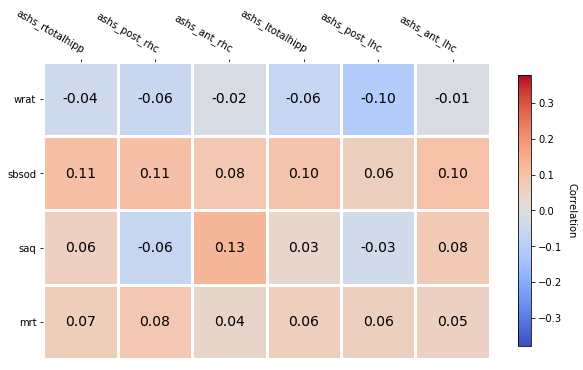

In [26]:
noReturn = corrPlot(non_silcton_measures,hipp_measures,data)

if saveFigFlag:
    plt.savefig('non_silcton_with_hipp_measures_corrPlot.pdf', transparent=True)
plt.show()



wrat
F =  4.823753810443293 p =  0.010554609859842318


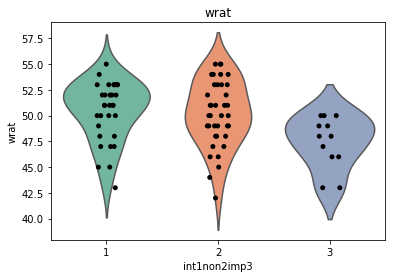

sbsod
F =  4.210261363116376 p =  0.01797502756687896


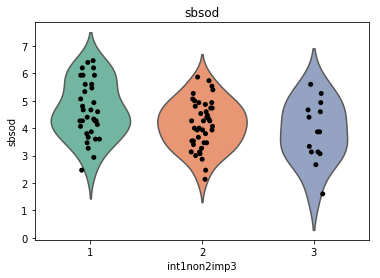

saq
F =  0.47810297163948645 p =  0.6215774976171307


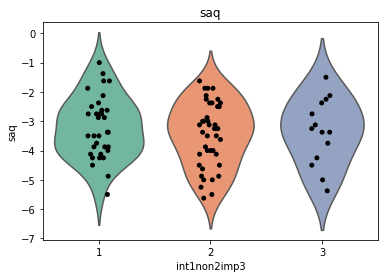

mrt
F =  3.304362698113556 p =  0.041383484493142095


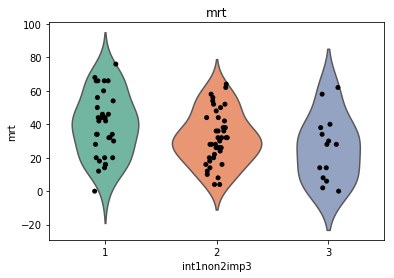

In [27]:
for i in non_silcton_measures:
    print(i)
    doAnova(i,data,groups='int1non2imp3')
    sns.violinplot(x='int1non2imp3',y=i,data=data,inner=None,palette='Set2')
    sns.stripplot(x='int1non2imp3',y=i,data=data,color='black',jitter=True)
    plt.title(i)
    plt.show()

## Non Silcton measures with other brain measures

C:\Users\stweis\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:106: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


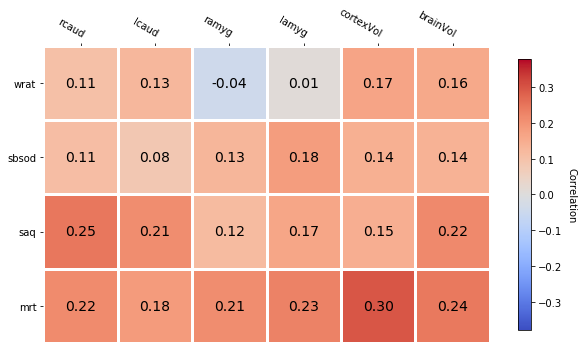

In [28]:
noReturn = corrPlot(non_silcton_measures,other_brain_measures,data)
if saveFigFlag:
    plt.savefig('non_silcton_with_other_brain_measures_corrPlot.pdf', transparent=True)
plt.show()




## Full correlation table

### Full data

C:\Users\stweis\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:106: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


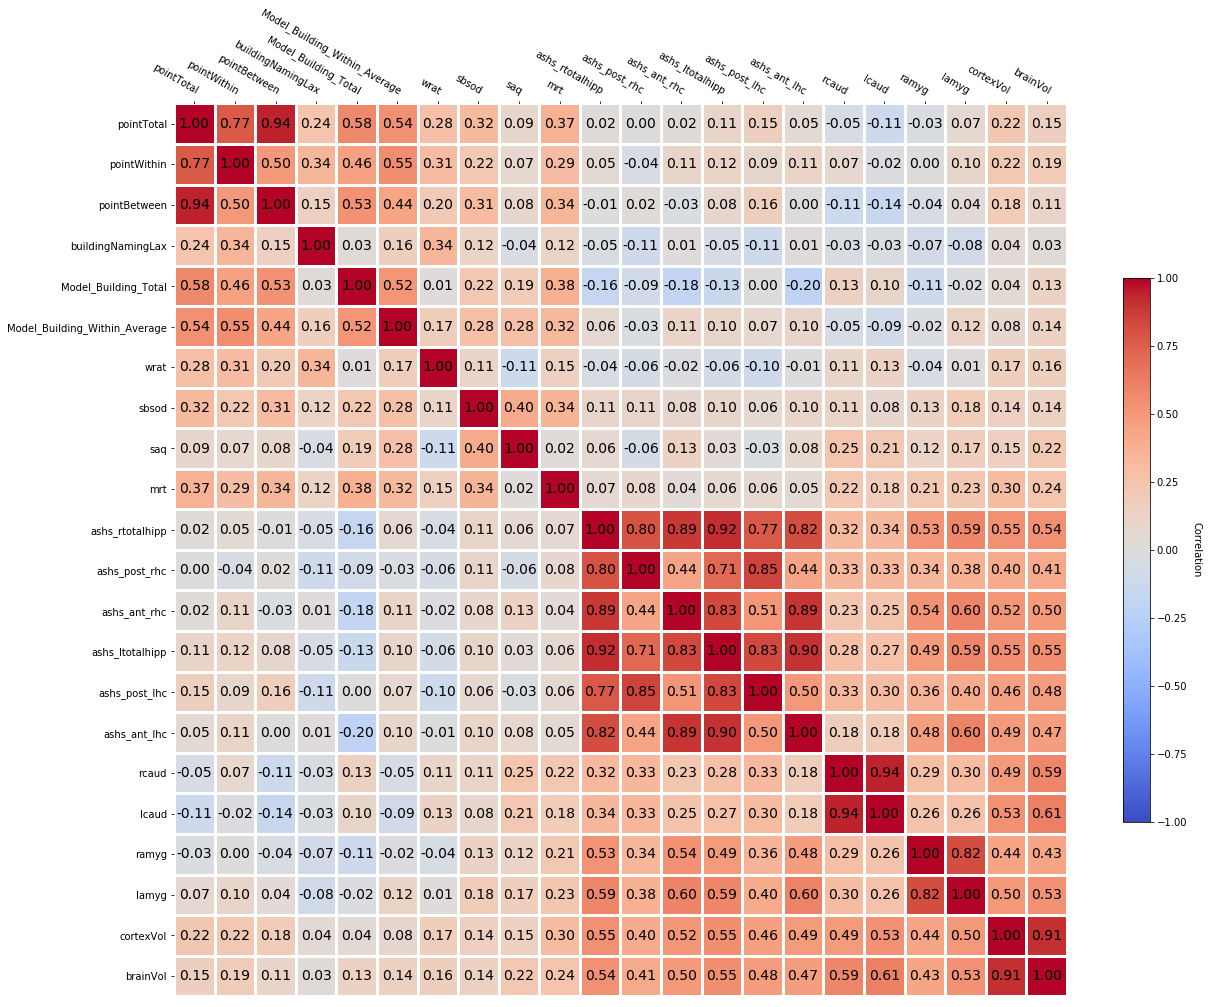

In [29]:
heatMapAll = corrPlot(silcton_measures+other_silcton_measures+non_silcton_measures+hipp_measures+other_brain_measures,
                      silcton_measures+other_silcton_measures+non_silcton_measures+hipp_measures+other_brain_measures,
                      data,xSize=20,ySize=20,max_corr=1,min_corr=-1)
if saveFigFlag:
    plt.savefig('full_corrPlot.pdf', transparent=True)
    
plt.show()





### Without Outliers

C:\Users\stweis\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:106: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


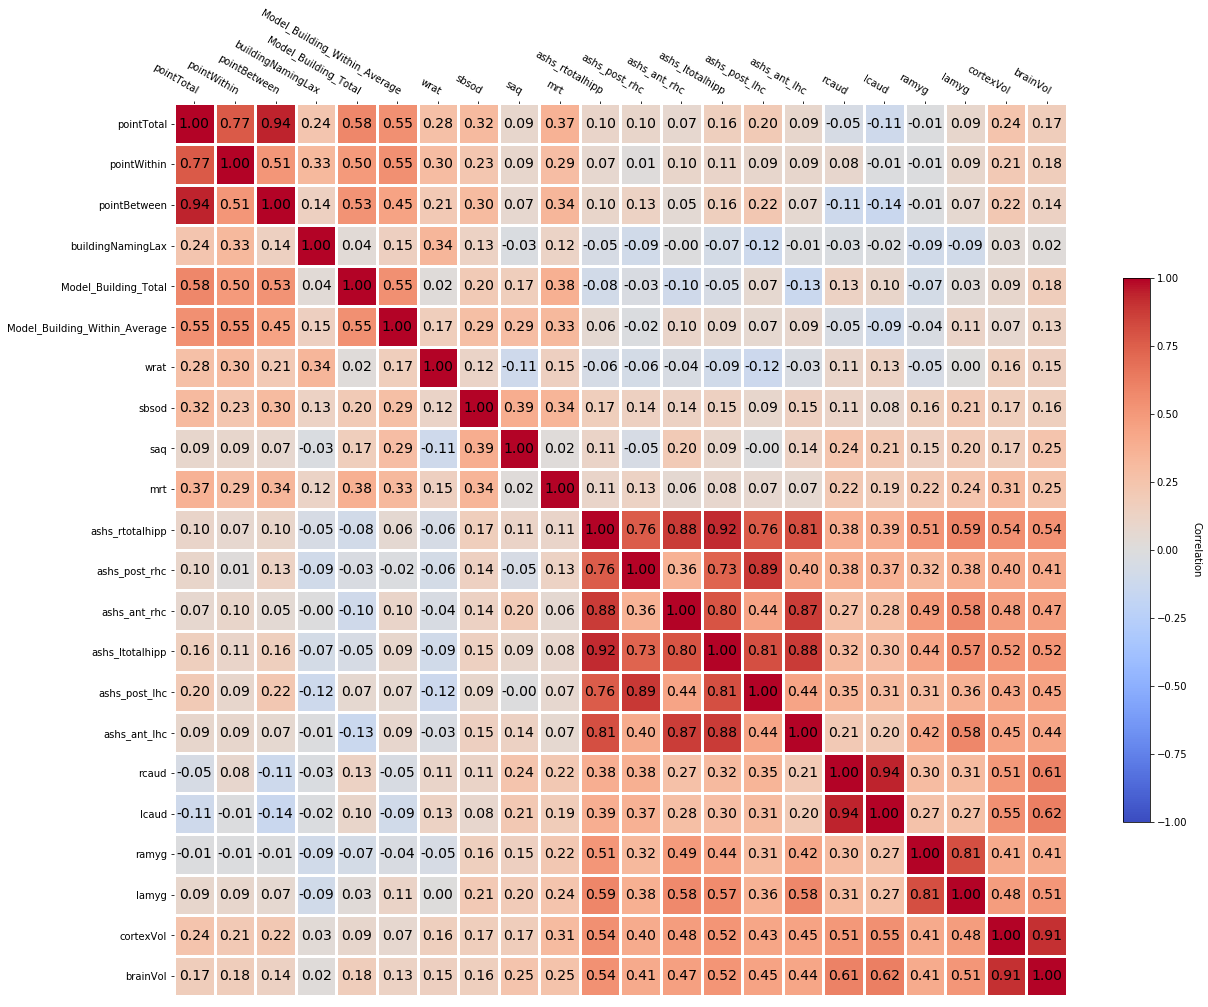

In [30]:
noReturn = corrPlot(silcton_measures+other_silcton_measures+non_silcton_measures+hipp_measures+other_brain_measures,
                    silcton_measures+other_silcton_measures+non_silcton_measures+hipp_measures+other_brain_measures,
                    dataWithoutOutliers,xSize=20,ySize=20,max_corr=1,min_corr=-1)

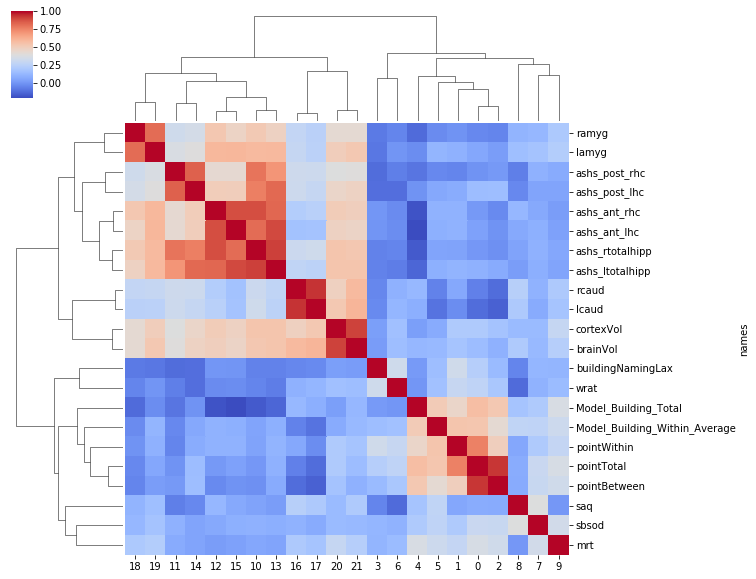

In [31]:
heatMapAll['names'] = all_measures
heatMapAll.set_index('names',inplace=True)
sns.clustermap(heatMapAll, cmap='coolwarm')


## Select scatterplots from exploratory analyses

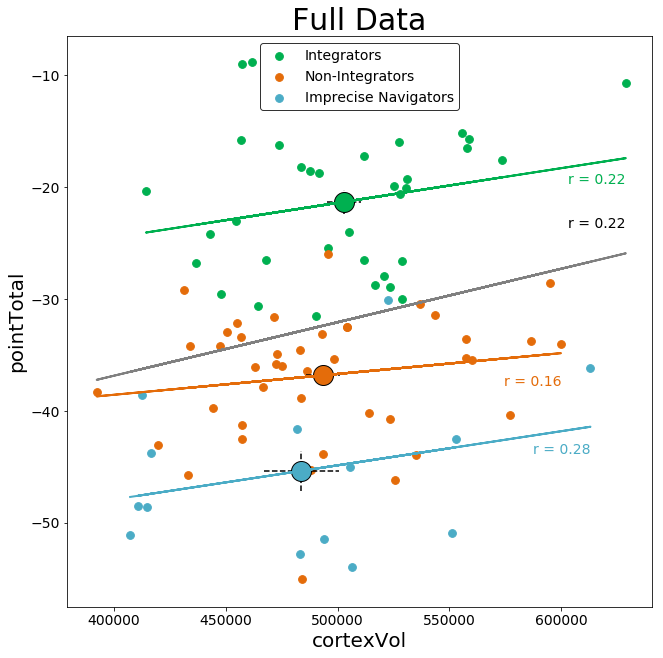

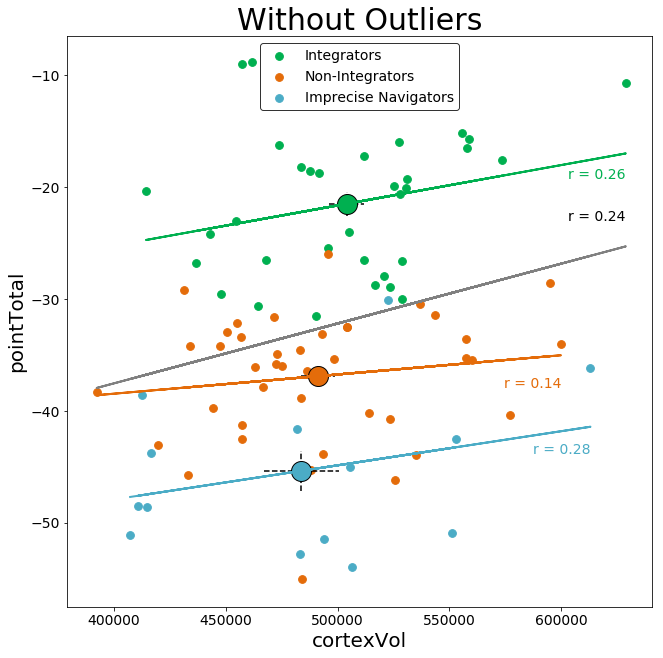

In [32]:
makeNavGroupPlot('cortexVol','pointTotal',data,title='Full Data')
makeNavGroupPlot('cortexVol','pointTotal',dataWithoutOutliers,title='Without Outliers')


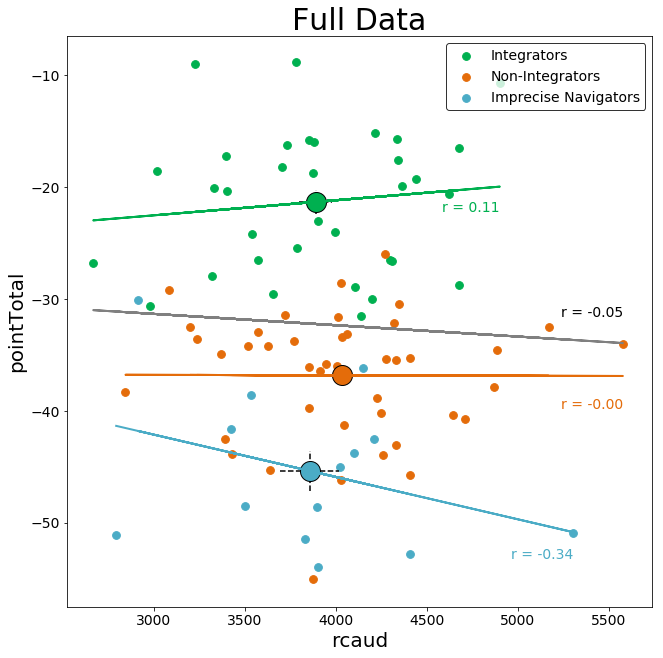

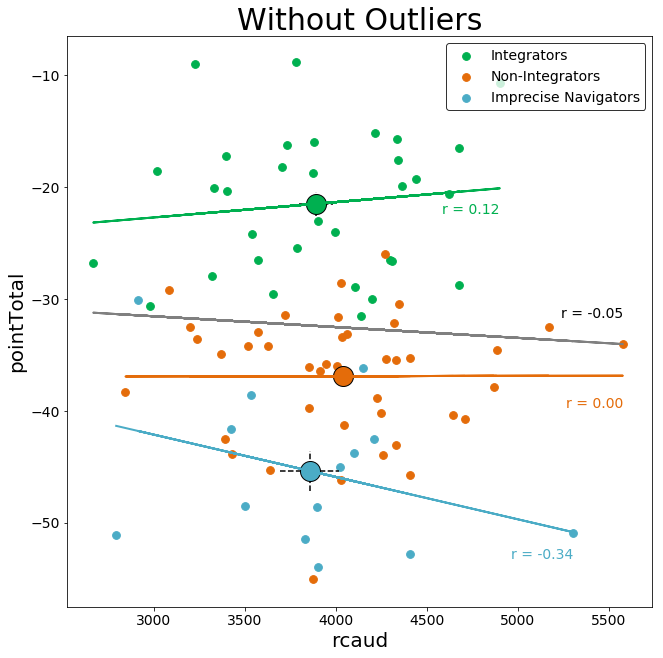

In [33]:
makeNavGroupPlot('rcaud','pointTotal',data,title='Full Data')
makeNavGroupPlot('rcaud','pointTotal',dataWithoutOutliers,title='Without Outliers')

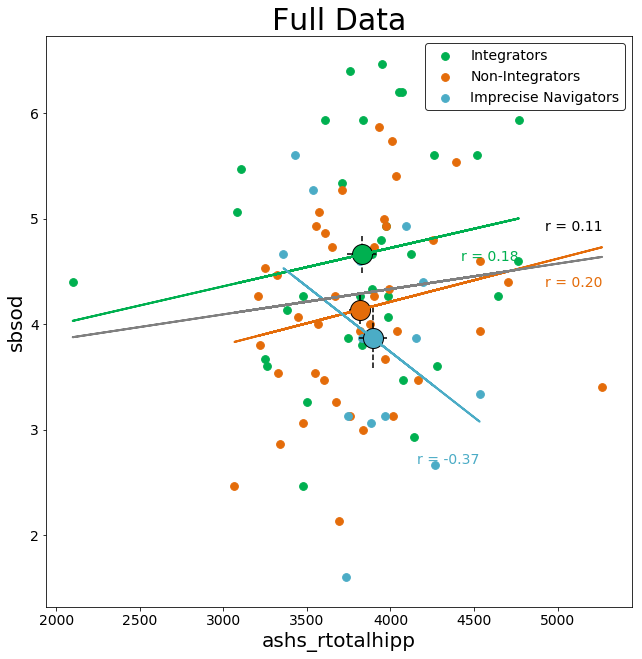

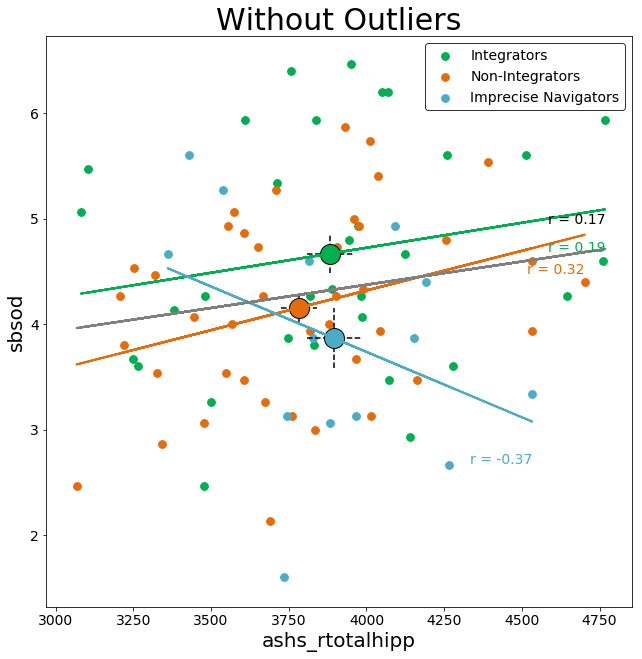

In [34]:
makeNavGroupPlot('ashs_rtotalhipp','sbsod',data,title='Full Data')
makeNavGroupPlot('ashs_rtotalhipp','sbsod',dataWithoutOutliers,title='Without Outliers')

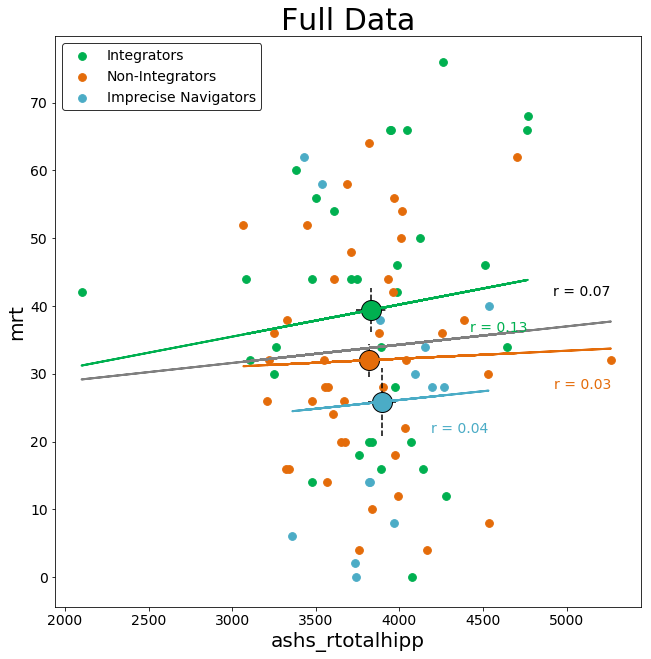

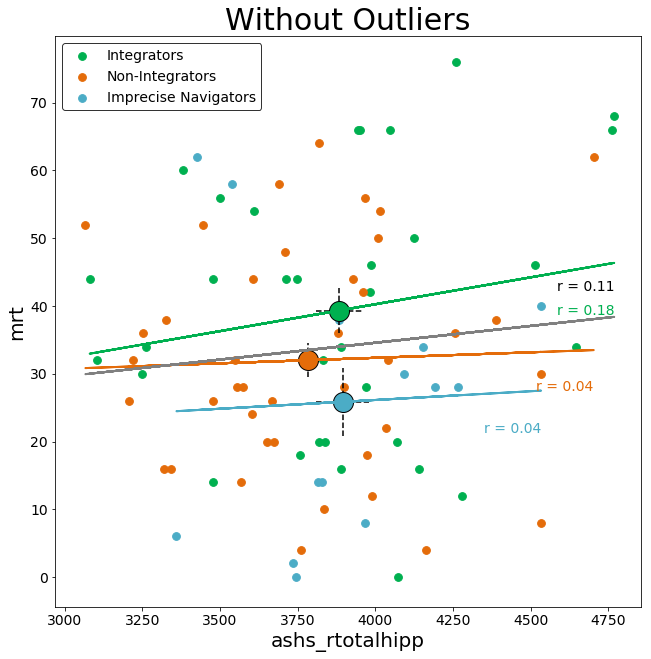

In [35]:
makeNavGroupPlot('ashs_rtotalhipp','mrt',data,title='Full Data')
makeNavGroupPlot('ashs_rtotalhipp','mrt',dataWithoutOutliers,title='Without Outliers')

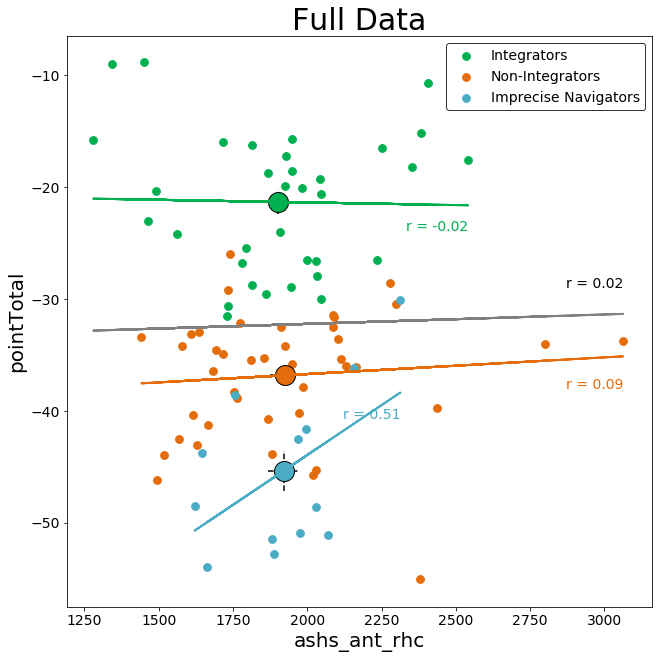

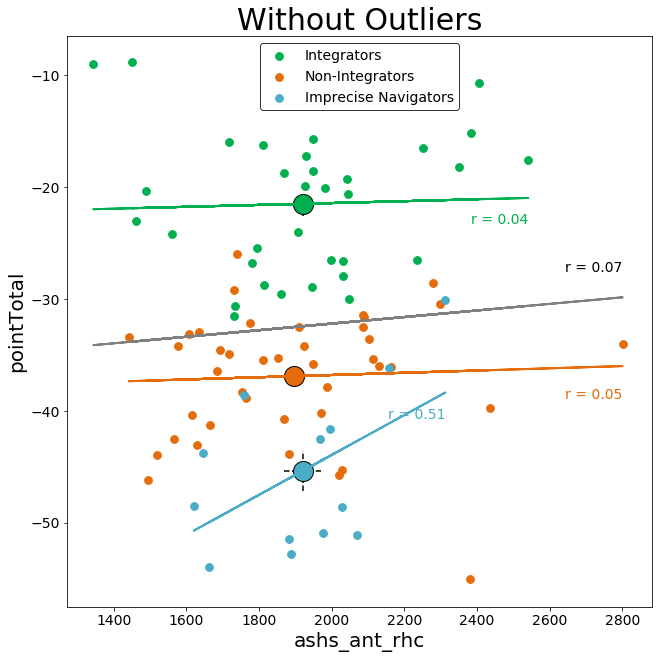

In [36]:
makeNavGroupPlot('ashs_ant_rhc','pointTotal',data,title='Full Data')
makeNavGroupPlot('ashs_ant_rhc','pointTotal',dataWithoutOutliers, title='Without Outliers')

C:\Users\stweis\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:106: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


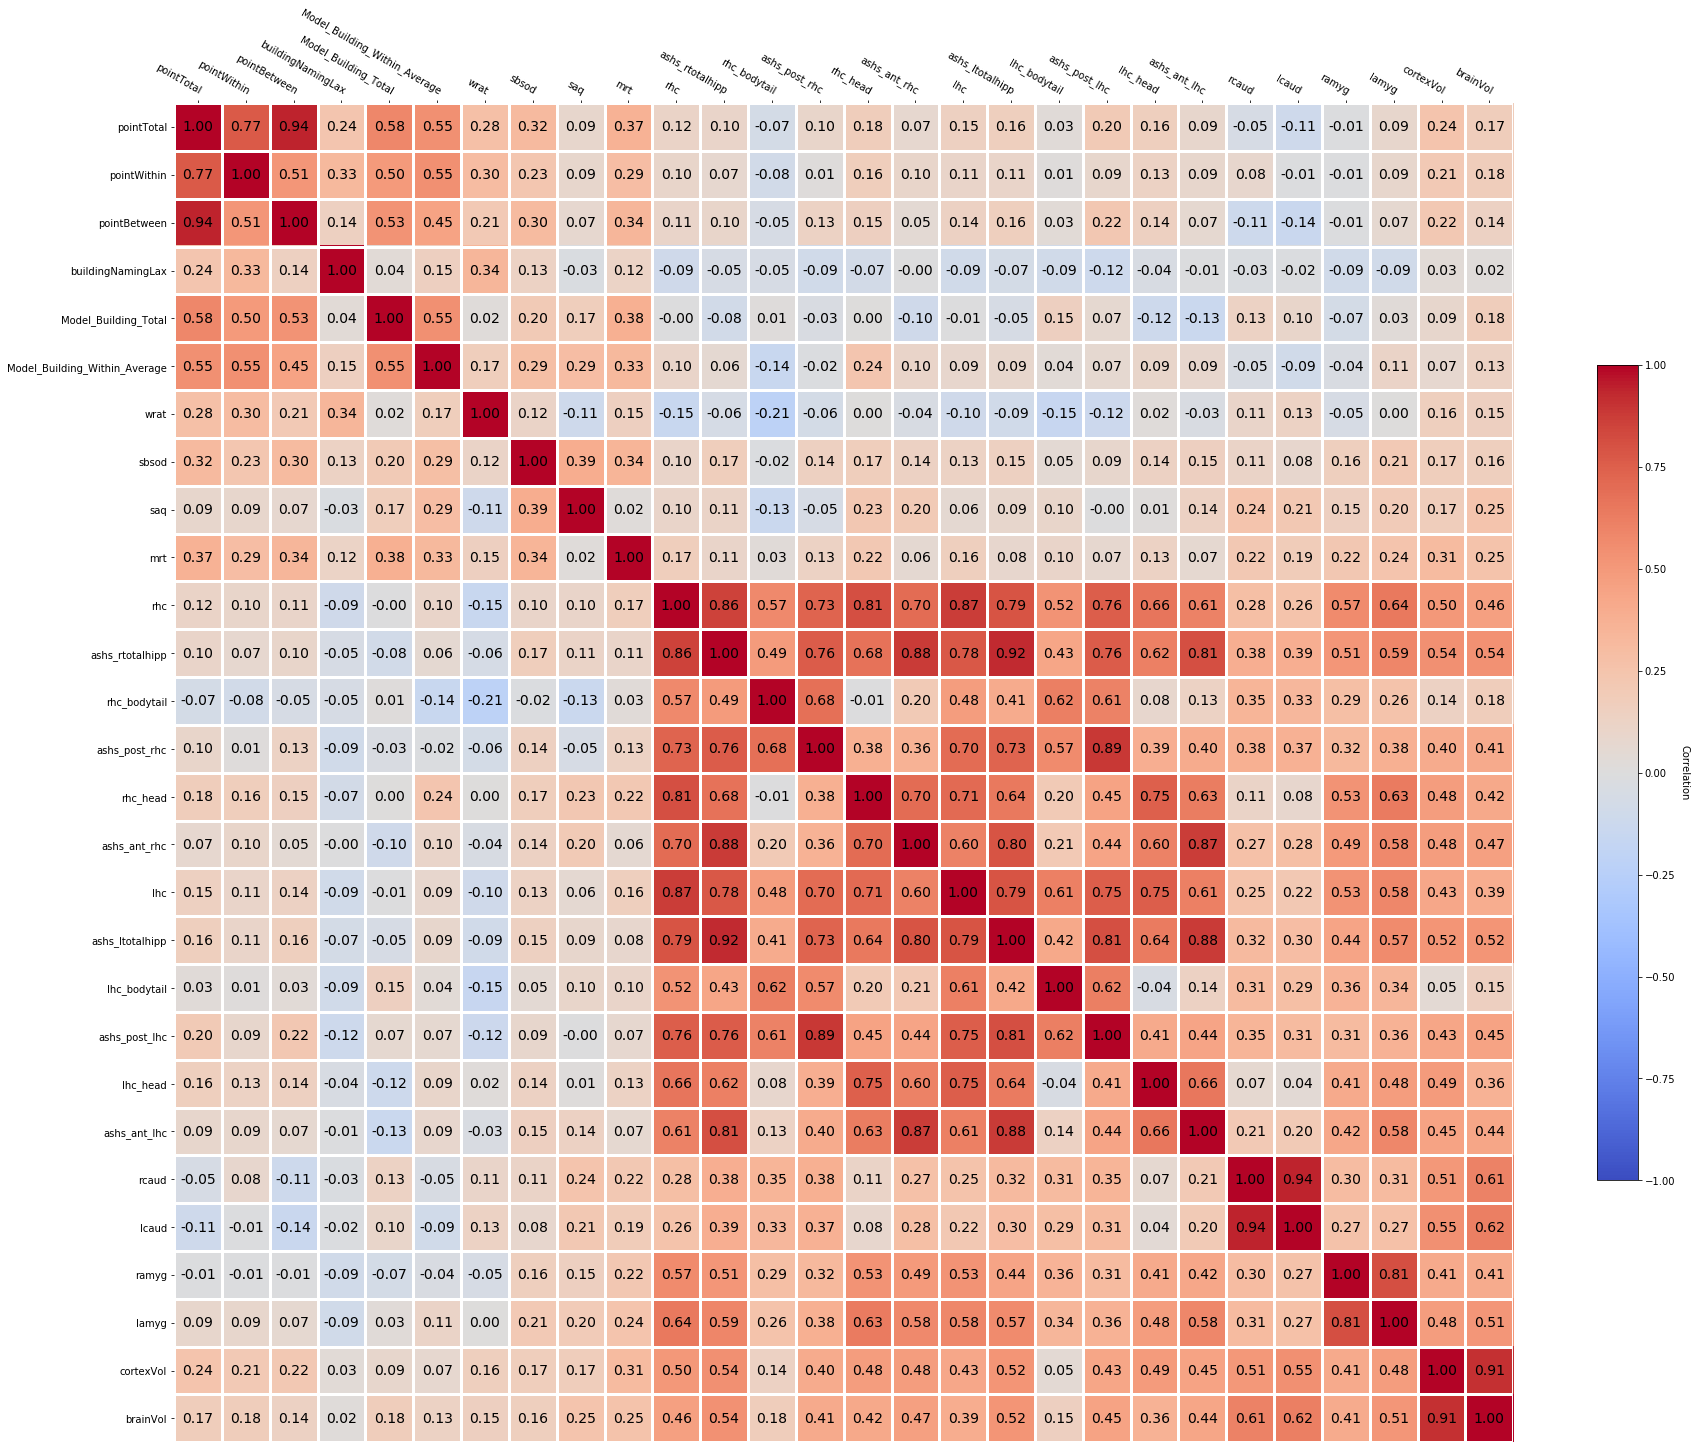

In [37]:
noReturn = corrPlot(silcton_measures+other_silcton_measures+non_silcton_measures+all_hipp_measures+other_brain_measures,
                    silcton_measures+other_silcton_measures+non_silcton_measures+all_hipp_measures+other_brain_measures,
                    dataWithoutOutliers,xSize=30,ySize=30,max_corr=1,min_corr=-1)

In [38]:

maleSplit = data[data['gender']=='Male']
femaleSplit = data[data['gender']=='Female']

for i in silcton_measures + other_silcton_measures + non_silcton_measures:
    #sns.violinplot(x='gender',y=i,data=data,inner=None,palette='Set2')
    #sns.stripplot(x='gender',y=i,data=data,color='black',jitter=True)
    #plt.ylim()
    #if saveFigFlag:
    #    plt.savefig(i+'_violinPlot.pdf', transparent=True)
    #plt.show()
    if i == 'wrat':
        display(i,scipy.stats.ttest_ind(maleSplit.dropna()[i],femaleSplit.dropna()[i]))
    else:
        display(i,scipy.stats.ttest_ind(maleSplit[i], femaleSplit[i]))
    


'pointTotal'

Ttest_indResult(statistic=1.6218780598305822, pvalue=0.10840705670466938)

'pointWithin'

Ttest_indResult(statistic=1.6956169751818488, pvalue=0.09349391840955955)

'pointBetween'

Ttest_indResult(statistic=1.274263562858776, pvalue=0.20592485949321634)

'buildingNamingLax'

Ttest_indResult(statistic=-1.56723181547554, pvalue=0.12064955864125394)

'Model_Building_Total'

Ttest_indResult(statistic=1.172640614810401, pvalue=0.24410453782297215)

'Model_Building_Within_Average'

Ttest_indResult(statistic=2.2089774539770657, pvalue=0.02977367972128086)

'wrat'

Ttest_indResult(statistic=0.00834772134700945, pvalue=0.9933614331072887)

'sbsod'

Ttest_indResult(statistic=3.4217692778388016, pvalue=0.000945777377152782)

'saq'

Ttest_indResult(statistic=3.2911850592627836, pvalue=0.0014367309334253305)

'mrt'

Ttest_indResult(statistic=2.1876111877628728, pvalue=0.03134872054023337)

In [39]:
for i in hipp_measures + other_brain_measures:
    #sns.violinplot(x='gender',y=i,data=data, inner=None,palette='Set2')
    #sns.stripplot(x='gender',y=i,data=data,color='black',jitter=True)
    #if saveFigFlag:
    #    plt.savefig(i+'_violinPlot.pdf', transparent=True)
    #plt.show()
   display(i,scipy.stats.ttest_ind(maleSplit[i], femaleSplit[i]))

'ashs_rtotalhipp'

Ttest_indResult(statistic=4.3755978959157495, pvalue=3.3175136739567396e-05)

'ashs_post_rhc'

Ttest_indResult(statistic=3.4198212925483875, pvalue=0.0009517681132407258)

'ashs_ant_rhc'

Ttest_indResult(statistic=3.767793071039912, pvalue=0.0002972731921775588)

'ashs_ltotalhipp'

Ttest_indResult(statistic=4.52032145743675, pvalue=1.915033149354125e-05)

'ashs_post_lhc'

Ttest_indResult(statistic=4.0442430404265455, pvalue=0.00011230960707998345)

'ashs_ant_lhc'

Ttest_indResult(statistic=3.6541537800533157, pvalue=0.0004381018181732891)

'rcaud'

Ttest_indResult(statistic=2.7778341957237735, pvalue=0.006687637096636168)

'lcaud'

Ttest_indResult(statistic=2.9029309926535696, pvalue=0.0046717666049556775)

'ramyg'

Ttest_indResult(statistic=4.215900330770124, pvalue=6.0124868268750595e-05)

'lamyg'

Ttest_indResult(statistic=4.536276178813934, pvalue=1.8013923221561413e-05)

'cortexVol'

Ttest_indResult(statistic=5.7637946692838335, pvalue=1.1949035065919976e-07)

'brainVol'

Ttest_indResult(statistic=6.30133937329672, pvalue=1.1371842154997217e-08)

C:\Users\stweis\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


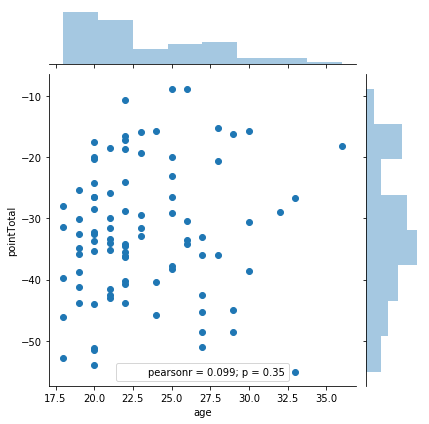

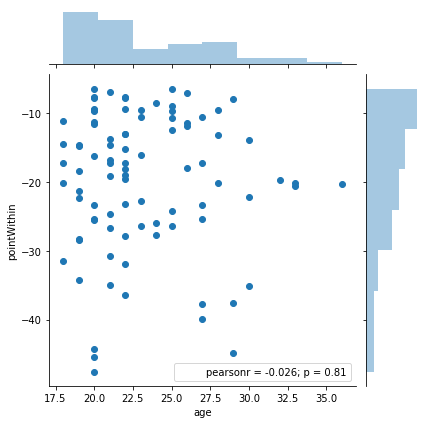

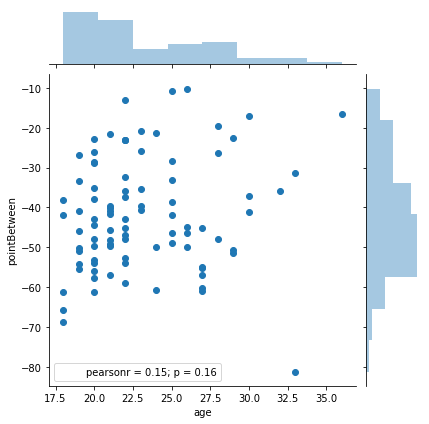

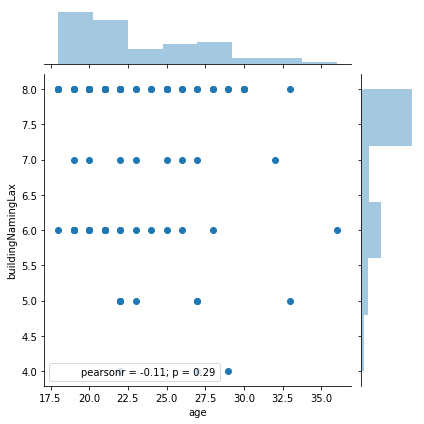

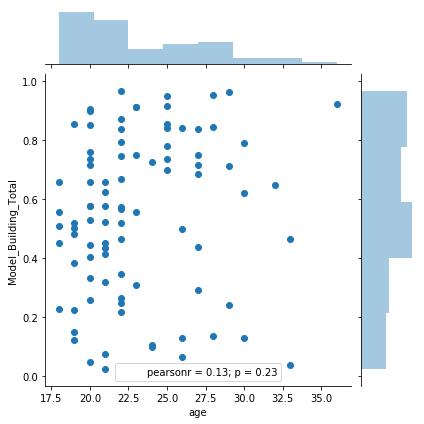

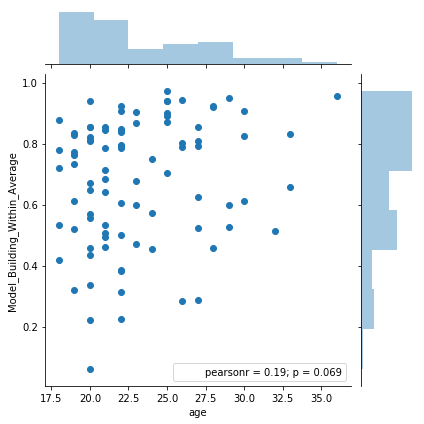

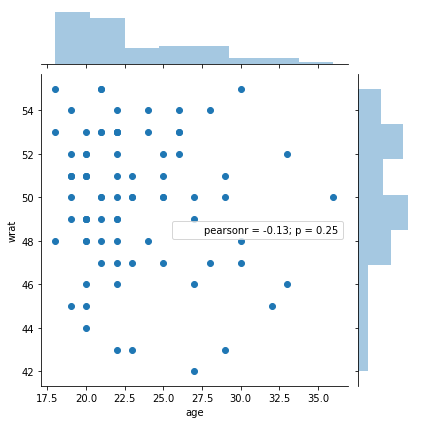

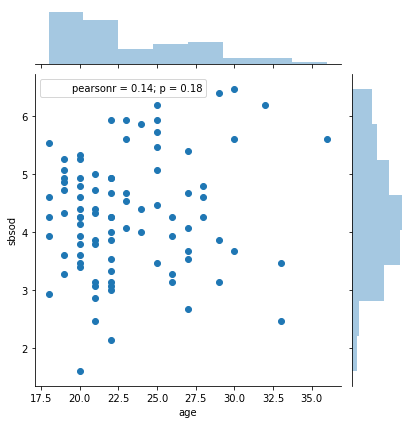

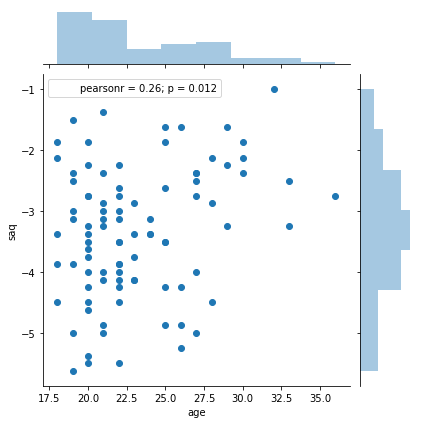

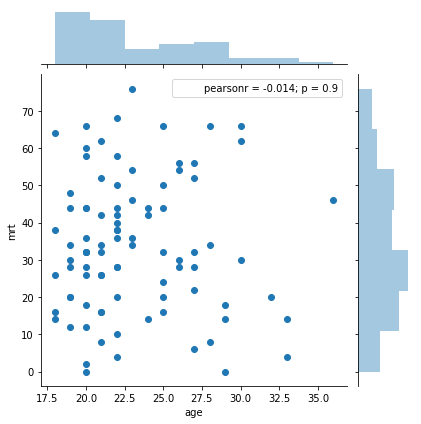

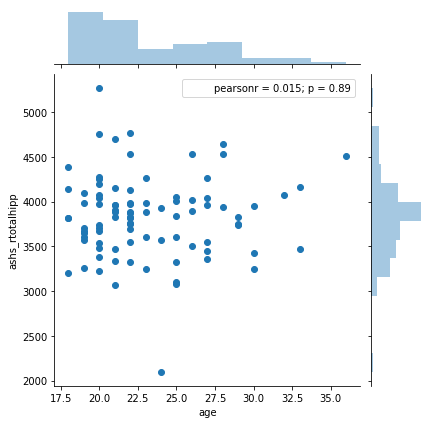

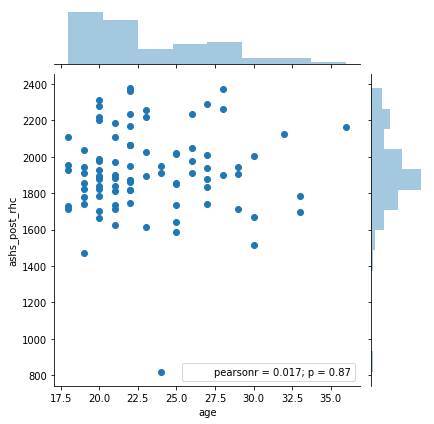

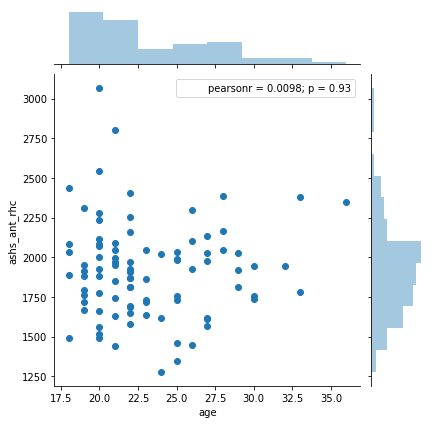

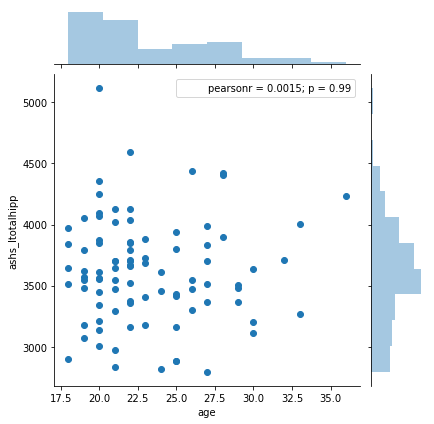

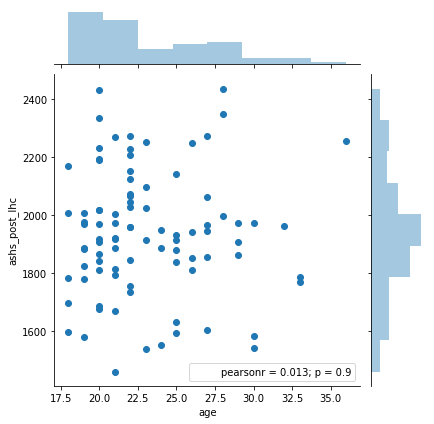

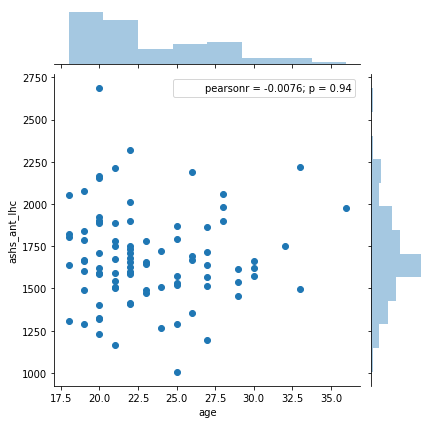

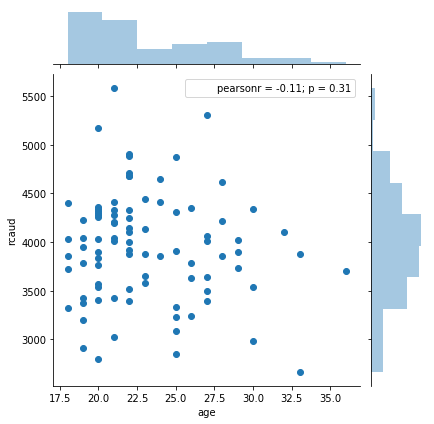

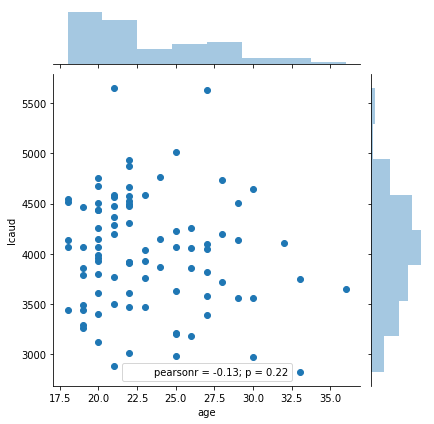

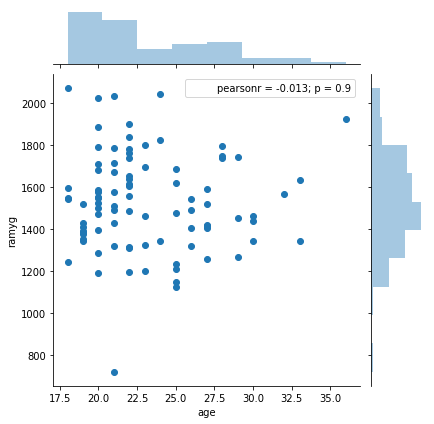

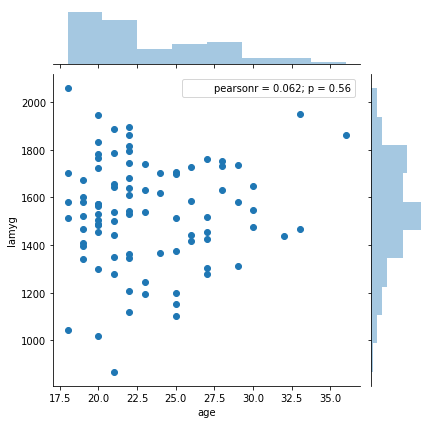

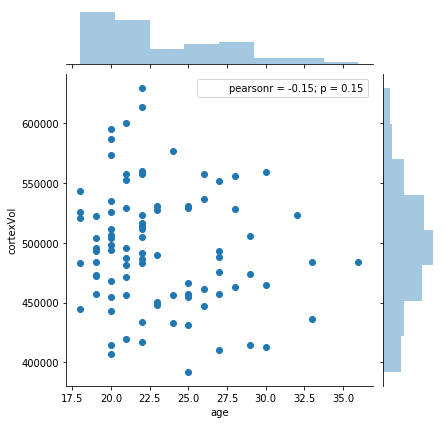

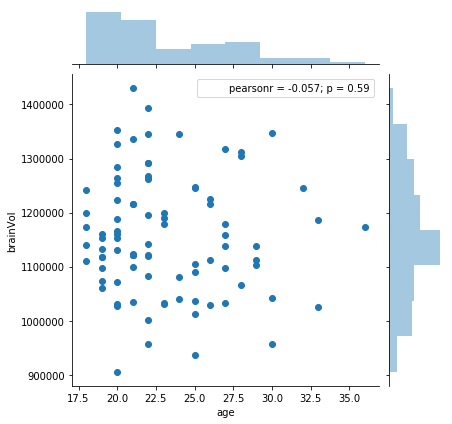

In [40]:
for i in all_measures:
    sns.jointplot(x='age',y=i,data=data)
    

# Hypothetical Figure


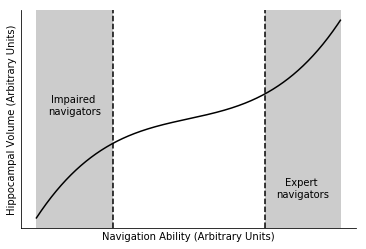

In [41]:
# A model of how results from impaired and expert groups may yield significant correlations with navigation ability while 
# typical populations would show no correlation. 

# These numbers are arbitrary. 
t2 = np.arange(0, 8, 0.01)
t3 = ((t2-4)**3) + t2*8 + 64

# Formatting 
fig, ax = plt.subplots()
ax.plot(t2,t3,color='black')
ax.xaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_major_locator(plt.NullLocator())
ax.set_xlabel('Navigation Ability (Arbitrary Units)')
ax.set_ylabel('Hippocampal Volume (Arbitrary Units)')

plt.axvline(2, color='black', linestyle='dashed')
plt.axvline(6, color='black', linestyle='dashed')
plt.axvspan(0,2, facecolor='black', alpha=0.2)
plt.axvspan(6,8, facecolor='black', alpha=0.2)

ax.text(7,20, 'Expert \nnavigators', horizontalalignment='center')
ax.text(1,100, 'Impaired \nnavigators', horizontalalignment='center')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
if saveFigFlag:
    plt.savefig('hypothetical_figure.pdf', transparent=True)